## Applied Data Science Capstone Project
### Week 5 - Segmenting and Clustering Neighborhoods in Toronto
### Kevin Spradlin
### August 1 - xxx, 2021

## Part 1 - Webscrape Postal Codes, Boroughs, and Neighborhoods

In [1]:
!pip install bs4
!pip install html5lib
#!pip install requests

In [2]:
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page
import pandas as pd

### Retrieve the page with the Toronto postal code, borough, and neighborhood table

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

data  = requests.get(url).text

#soup = BeautifulSoup(data,"html5lib")
soup = BeautifulSoup(data,"html.parser")


In [4]:
#print(soup.prettify())

#find all html tables in the web page
tables = soup.find_all('table') # in html table is represented by the tag <table>

len(tables)


3

### Find the table with the postal codes.  It's the one with 'Not assigned' in some of its cells.

In [5]:
# find the table with the postal codes
for index,table in enumerate(tables):
    if ("Not assigned" in str(table)):
        table_index = index
print(table_index)

#print(tables[table_index].prettify())


0


### Extract the table's data into a list, then copy it into a _pandas_ dataframe.  You need to simplify some boroughs' names.

In [6]:
# extract the postal codes, boroughs, and neighborhoods into a list
table_contents = []

for row in tables[table_index].findAll("td"):
  cell = {}

  if row.span.text == "Not assigned":
    pass
  else:
    cell["PostalCode"] = row.p.text[:3]
    cell["Borough"] = (row.span.text).split('(')[0]
    cell["Neighborhood"] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
    table_contents.append(cell)

#print(table_contents)


In [7]:
# convert the list with postal codes, boroughs, and neighborhoods into a pandas dataframe
df = pd.DataFrame(table_contents)

#df.Borough.unique()

df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                     'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                     'EtobicokeNorthwest':'Etobicoke Northwest',
                                     'East YorkEast Toronto':'East York/East Toronto',
                                     'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

#df.Borough.unique()


In [8]:
# print the dimensions of the dataframe
df.shape

(103, 3)

### The dataframe has 103 rows (postal codes for boroughs and neighborhoods).

## Part 2 - Get the latitude and longitude of each postal code

In [9]:
!pip install geocoder
import geocoder


### Read the data in the csv file into a dictionary, then combine it and the postal code/borough/neighborhood data into a new _toronto_data_ dataframe.

In [10]:
# read the coordinates from the csv file into a dictionary.
lat_long_coords = {}

geodata = open('Geospatial_Coordinates.csv', 'r')

for curr_line in geodata:
  postal_code, latitude, longitude = curr_line.split(',')

  lat_long_coords[postal_code] = (latitude, longitude[:-1], )


geodata.close()


In [11]:
# loop through the rows in the dataframe, putting the combined postal code/borough/neighborhood/latitude and longitude information into a new dataframe
full_table_contents = []


for index, row in df.iterrows():
  cell = {}
  cell["PostalCode"] = row["PostalCode"]  
  cell["Borough"] = row["Borough"]  
  cell["Neighborhood"] = row["Neighborhood"]  

  if row["PostalCode"] in lat_long_coords:
    cell["Latitude"] = lat_long_coords[row["PostalCode"]][0]
    cell["Longitude"] = lat_long_coords[row["PostalCode"]][1]

  full_table_contents.append(cell)


toronto_data = pd.DataFrame(full_table_contents)

toronto_data.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.7532586,-79.3296565
1,M4A,North York,Victoria Village,43.7258823,-79.3155716
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6542599,-79.3606359
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.4647633
4,M7A,Queen's Park,Ontario Provincial Government,43.6623015,-79.3894938


In [12]:
toronto_data.shape

(103, 5)

### The new dataframe has 103 rows, or the same number as the original dataframe.  So no rows were left out.

## Part 3 - Explore the Neighborhoods in Toronto

### Create a map of the neighborhoods in Toronto

In [13]:
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
!pip install sklearn
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip install folium
import folium # map rendering library


### First set up an instance of geocoder for Toronto

In [14]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Now create the map of Toronto

In [15]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Define the Foursquare API credentials

In [16]:
CLIENT_ID = 'FFLI1QQCW1LJXXOSTNDXAYO32RNNNTMFZL4OOKJGLIHNWJUR' # your Foursquare ID
CLIENT_SECRET = 'LQLDT1TZOE4AK2RRK5EJ2JALLUAIZI5BQYQWFDJS3B25M2XU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


### Define a function to get venues near a neighborhood

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Gather the venues in each neighborhood into the _toronto_venues_ dataframe

In [18]:
toronto_venues = getNearbyVenues(names = toronto_data['Neighborhood'],
                                 latitudes = toronto_data['Latitude'],
                                 longitudes = toronto_data['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

### Check the size of the _toronto_venues_ dataframe, the number of venues in each neighborhood, and the number of distinct venue categories

In [19]:
print(toronto_venues.shape)
toronto_venues.head()

(2145, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.7532586,-79.3296565,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.7532586,-79.3296565,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.7532586,-79.3296565,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.7258823,-79.3155716,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.7258823,-79.3155716,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [20]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
Willowdale West,6,6,6,6,6,6
"Willowdale, Newtonbrook",3,3,3,3,3,3
Woburn,4,4,4,4,4,4


In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


## Part 4 - Identify and Analyze Health-Related Venues in Toronto

### Next, list the different types of venues and determine the ones that are associated with a healthy lifestyle.  Then filter the _toronto_venues_ dataframe to only include the health-related venues.

In [22]:
toronto_venues['Venue Category'].unique()

array(['Park', 'Fast Food Restaurant', 'Food & Drink Shop',
       'Hockey Arena', 'Coffee Shop', 'Portuguese Restaurant',
       'French Restaurant', 'Bakery', 'Distribution Center', 'Restaurant',
       'Spa', 'Gym / Fitness Center', 'Historic Site', 'Chocolate Shop',
       'Pub', 'Farmers Market', 'Performing Arts Venue', 'Breakfast Spot',
       'Dessert Shop', 'Mexican Restaurant', 'Theater', 'Yoga Studio',
       'Event Space', 'Shoe Store', 'Café', 'Asian Restaurant',
       'Art Gallery', 'Electronics Store', 'Bank', 'Beer Store',
       'Antique Shop', 'Boutique', 'Furniture / Home Store',
       'Vietnamese Restaurant', 'Clothing Store', 'Accessories Store',
       'Miscellaneous Shop', 'Italian Restaurant', 'Beer Bar',
       'Sushi Restaurant', 'Creperie', 'Fried Chicken Joint',
       'Hobby Shop', 'Burrito Place', 'Diner', 'Japanese Restaurant',
       'Smoothie Shop', 'Sandwich Place', 'Gym', 'College Auditorium',
       'Bar', 'General Entertainment', 'Print Shop',
   

In [23]:
toronto_healthy_venue_names = ['Athletics & Sports', 'Baseball Field', 'Basketball Court', 'Climbing Gym', 
                               'Fruit & Vegetable Store', 'Gym', 'Gym / Fitness Center', 'Health Food Store', 
                               'Juice Bar', 'Park', 'Pool', 'Salad Place', 'Soccer Field', 
                               'Tennis Court', 'Trail', 'Vegetarian / Vegan Restaurant', 'Yoga Studio']
toronto_health_venues = toronto_venues[toronto_venues['Venue Category'].isin(toronto_healthy_venue_names)]

print('{} neighborhoods have at least one health-related venue.'.format(len(toronto_health_venues['Neighborhood'].unique())))
print('There are {} uniques categories.'.format(len(toronto_health_venues['Venue Category'].unique())))

68 neighborhoods have at least one health-related venue.
There are 17 uniques categories.


### Then, reshape the venue data.

In [24]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_health_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_health_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = list(toronto_onehot.columns.values)
cols.pop(cols.index('Neighborhood'))
toronto_onehot = toronto_onehot[['Neighborhood'] + cols]

toronto_onehot.head()


,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Climbing Gym,Fruit & Vegetable Store,Gym,Gym / Fitness Center,Health Food Store,Juice Bar,Park,Pool,Salad Place,Soccer Field,Tennis Court,Trail,Vegetarian / Vegan Restaurant,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
12,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
13,"Regent Park, Harbourfront",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
25,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
32,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [25]:
toronto_onehot.shape

(191, 18)

### Next, group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [26]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Athletics & Sports,Baseball Field,Basketball Court,Climbing Gym,Fruit & Vegetable Store,Gym,Gym / Fitness Center,Health Food Store,Juice Bar,Park,Pool,Salad Place,Soccer Field,Tennis Court,Trail,Vegetarian / Vegan Restaurant,Yoga Studio
0,"Alderwood, Long Branch",0.5,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.5,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0
4,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.0,0.5,0.0,0.500000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,"University of Toronto, Harbord",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.0
64,Willowdale South,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
65,"Willowdale, Newtonbrook",0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.000000,0.666667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
66,Woodbine Heights,0.5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.500000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [27]:
toronto_grouped.shape

(68, 18)

### Print each neighborhood (that has at least one health-related venue) with its five most common healthy venues

In [28]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alderwood, Long Branch----
                           venue  freq
0             Athletics & Sports   0.5
1                            Gym   0.5
2                           Park   0.0
3  Vegetarian / Vegan Restaurant   0.0
4                          Trail   0.0


----Bathurst Manor, Wilson Heights, Downsview North----
                           venue  freq
0                           Park   0.5
1              Health Food Store   0.5
2             Athletics & Sports   0.0
3  Vegetarian / Vegan Restaurant   0.0
4                          Trail   0.0


----Bedford Park, Lawrence Manor East----
                           venue  freq
0                      Juice Bar   1.0
1                           Park   0.0
2  Vegetarian / Vegan Restaurant   0.0
3                          Trail   0.0
4                   Tennis Court   0.0


----Berczy Park----
                           venue  freq
0                      Juice Bar  0.33
1                           Park  0.33
2  Vegetarian / Vegan Rest

### Put this information into a new _pandas_ dataframe.  First write a function that puts each neighborhood's data into descending order.  Then use it to create the new dataframe.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Went from 10 most common venues to 5 most common, since there are only 17 health-related venues out of 274 unique types of venues.

In [30]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Alderwood, Long Branch",Athletics & Sports,Gym,Park,Vegetarian / Vegan Restaurant,Trail
1,"Bathurst Manor, Wilson Heights, Downsview North",Park,Health Food Store,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail
2,"Bedford Park, Lawrence Manor East",Juice Bar,Park,Vegetarian / Vegan Restaurant,Trail,Tennis Court
3,Berczy Park,Juice Bar,Park,Vegetarian / Vegan Restaurant,Trail,Tennis Court
4,"Brockton, Parkdale Village, Exhibition Place",Climbing Gym,Gym,Athletics & Sports,Pool,Vegetarian / Vegan Restaurant


## Part 5 - Cluster Modeling of Health-Related Venues in Toronto

### First, use the elbow method to determine the optimal number of clusters

In [31]:
import matplotlib.pyplot as plt

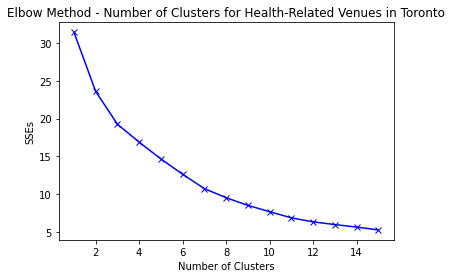

In [32]:
number_clusters = [x for x in range(1,16)]
clustering_errors = []

toronto_healthy_clustering = toronto_grouped.drop('Neighborhood', 1)

for kclusters in number_clusters:

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_healthy_clustering)

    # record the SSE
    clustering_errors.append(kmeans.inertia_)
    

plt.plot(number_clusters, clustering_errors, 'bx-')

plt.xlabel('Number of Clusters')
plt.ylabel('SSEs')
plt.title('Elbow Method - Number of Clusters for Health-Related Venues in Toronto')
plt.show()


### There is an elbow when there are 2 clusters.  However, it isn't very definitive.  Instead, I saw that the SSEs don't decrease by much beyond 12 clusters.  So, I started with 12 clusters and looked at the types of venues in the resulting clusters.  There were several with nearly identical types of venues.  So, I iteratively decreased the number of clusters until there weren't any with nearly identical types of venues.  I found that this result occurred when I used 8 clusters.

### Run a k-means cluster to sort the data into 8 neighborhoods.

In [33]:
# set number of clusters
kclusters = 8

toronto_healthy_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_healthy_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 3, 0, 5, 5, 7, 2, 5, 7, 5], dtype=int32)

### Use these clusters to create a new dataframe with the 5 most common venues

In [34]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.shape

(103, 11)

In [35]:
toronto_merged.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,North York,Parkwoods,43.7532586,-79.3296565,7.0,Park,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail,Tennis Court
1,M4A,North York,Victoria Village,43.7258823,-79.3155716,NaN,NaN,NaN,NaN,NaN,NaN
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6542599,-79.3606359,3.0,Park,Yoga Studio,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Trail
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.4647633,NaN,NaN,NaN,NaN,NaN,NaN
4,M7A,Queen's Park,Ontario Provincial Government,43.6623015,-79.3894938,5.0,Yoga Studio,Park,Gym,Vegetarian / Vegan Restaurant,Trail
5,M9A,Etobicoke,Islington Avenue,43.6678556,-79.5322424,NaN,NaN,NaN,NaN,NaN,NaN
6,M1B,Scarborough,"Malvern, Rouge",43.8066863,-79.1943534,NaN,NaN,NaN,NaN,NaN,NaN
7,M3B,North York,Don Mills North,43.7459058,-79.352188,6.0,Gym,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.7063972,-79.309937,2.0,Athletics & Sports,Gym / Fitness Center,Park,Vegetarian / Vegan Restaurant,Trail
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.6571618,-79.3789371,3.0,Gym,Gym / Fitness Center,Park,Athletics & Sports,Pool


In [36]:
toronto_merged[['Cluster Labels']].describe()

,Cluster Labels
count,68.000000
mean,4.382353
std,2.087843
min,0.000000
25%,3.000000
50%,5.000000
75%,6.000000
max,7.000000


### Remove the rows with NaN values in the 'Cluster Labels' column, since they don't have any health-related venues.

In [37]:
indices_to_drop = []

for index, row in toronto_merged.iterrows():
  if np.isnan(row['Cluster Labels']):
    indices_to_drop.append(index)
 
 

toronto_merged.drop(indices_to_drop, inplace = True)
toronto_merged.describe()

,Cluster Labels
count,68.000000
mean,4.382353
std,2.087843
min,0.000000
25%,3.000000
50%,5.000000
75%,6.000000
max,7.000000


### Put the information in the new dataframe onto a map.

In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the clusters, to determine which venues determine the differences between them.

### Cluster 1 - 

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
33,M2J,"Fairview, Henry Farm, Oriole",0.0,Juice Bar,Health Food Store,Baseball Field,Pool,Vegetarian / Vegan Restaurant
55,M5M,"Bedford Park, Lawrence Manor East",0.0,Juice Bar,Park,Vegetarian / Vegan Restaurant,Trail,Tennis Court
59,M2N,Willowdale South,0.0,Juice Bar,Park,Vegetarian / Vegan Restaurant,Trail,Tennis Court


### Cluster 2 - Trails and parks are the most common venues in this cluster.

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
16,M6C,Humewood-Cedarvale,1.0,Trail,Tennis Court,Athletics & Sports,Park,Vegetarian / Vegan Restaurant
19,M4E,The Beaches,1.0,Trail,Health Food Store,Athletics & Sports,Park,Vegetarian / Vegan Restaurant
49,M6L,"North Park, Maple Leaf Park, Upwood Park",1.0,Park,Basketball Court,Trail,Athletics & Sports,Vegetarian / Vegan Restaurant
68,M5P,Forest Hill North & West,1.0,Trail,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Tennis Court
83,M4T,"Moore Park, Summerhill East",1.0,Trail,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Tennis Court


### Cluster 3 - Athletic and sport venues (e.g. - The Hangar @ Downsview Park) are the most common venues in this cluster.

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,M4B,"Parkview Hill, Woodbine Gardens",2.0,Athletics & Sports,Gym / Fitness Center,Park,Vegetarian / Vegan Restaurant,Trail
14,M4C,Woodbine Heights,2.0,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail,Tennis Court
26,M1H,Cedarbrae,2.0,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail,Tennis Court
60,M3N,Downsview Northwest,2.0,Athletics & Sports,Gym / Fitness Center,Park,Vegetarian / Vegan Restaurant,Trail
93,M8W,"Alderwood, Long Branch",2.0,Athletics & Sports,Gym,Park,Vegetarian / Vegan Restaurant,Trail


### Cluster 4 - 

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,M5A,"Regent Park, Harbourfront",3.0,Park,Yoga Studio,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Trail
9,M5B,"Garden District, Ryerson",3.0,Gym,Gym / Fitness Center,Park,Athletics & Sports,Pool
28,M3H,"Bathurst Manor, Wilson Heights, Downsview North",3.0,Park,Health Food Store,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail
29,M4H,Thorncliffe Park,3.0,Yoga Studio,Gym,Gym / Fitness Center,Park,Pool
31,M6H,"Dufferin, Dovercourt Village",3.0,Athletics & Sports,Park,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Trail
44,M1L,"Golden Mile, Clairlea, Oakridge",3.0,Park,Soccer Field,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail
54,M4M,Studio District,3.0,Yoga Studio,Park,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Trail
67,M4P,Davisville North,3.0,Park,Gym / Fitness Center,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail
73,M4R,North Toronto West,3.0,Yoga Studio,Park,Vegetarian / Vegan Restaurant,Trail,Tennis Court
96,M4X,"St. James Town, Cabbagetown",3.0,Park,Gym / Fitness Center,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail


### Cluster 5 - 

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
27,M2H,Hillcrest Village,4.0,Pool,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail
53,M3M,Downsview Central,4.0,Baseball Field,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail
57,M9M,"Humberlea, Emery",4.0,Baseball Field,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail
101,M8Y,"Old Mill South, King's Mill Park, Sunnylea, Hu...",4.0,Pool,Baseball Field,Athletics & Sports,Park,Vegetarian / Vegan Restaurant


### Cluster 6 - 

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,M7A,Ontario Provincial Government,5.0,Yoga Studio,Park,Gym,Vegetarian / Vegan Restaurant,Trail
15,M5C,St. James Town,5.0,Park,Gym,Vegetarian / Vegan Restaurant,Athletics & Sports,Trail
20,M5E,Berczy Park,5.0,Juice Bar,Park,Vegetarian / Vegan Restaurant,Trail,Tennis Court
24,M5G,Central Bay Street,5.0,Salad Place,Juice Bar,Gym / Fitness Center,Vegetarian / Vegan Restaurant,Park
30,M5H,"Richmond, Adelaide, King",5.0,Gym,Vegetarian / Vegan Restaurant,Salad Place,Juice Bar,Gym / Fitness Center
36,M5J,"Harbourfront East, Union Station, Toronto Islands",5.0,Park,Juice Bar,Vegetarian / Vegan Restaurant,Gym,Salad Place
37,M6J,"Little Portugal, Trinity",5.0,Juice Bar,Park,Vegetarian / Vegan Restaurant,Yoga Studio,Fruit & Vegetable Store
41,M4K,"The Danforth West, Riverdale",5.0,Juice Bar,Fruit & Vegetable Store,Trail,Yoga Studio,Climbing Gym
42,M5K,"Toronto Dominion Centre, Design Exchange",5.0,Salad Place,Vegetarian / Vegan Restaurant,Gym,Gym / Fitness Center,Athletics & Sports
43,M6K,"Brockton, Parkdale Village, Exhibition Place",5.0,Climbing Gym,Gym,Athletics & Sports,Pool,Vegetarian / Vegan Restaurant


### Cluster 7 - Gyms are the most common venues in this cluster.

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
7,M3B,Don Mills North,6.0,Gym,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail
13,M3C,Don Mills South,6.0,Gym,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail
50,M9L,Humber Summit,6.0,Gym,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail
76,M7R,Enclave of L4W,6.0,Gym,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail
88,M8V,"New Toronto, Mimico South, Humber Bay Shores",6.0,Gym,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail
102,M8Z,"Mimico NW, The Queensway West, South of Bloor,...",6.0,Gym,Athletics & Sports,Park,Vegetarian / Vegan Restaurant,Trail


### Cluster 8 - Parks are the most common venues in this cluster.

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 7.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M3A,Parkwoods,7.0,Park,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail,Tennis Court
21,M6E,Caledonia-Fairbanks,7.0,Park,Pool,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail
25,M6G,Christie,7.0,Park,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail,Tennis Court
35,M4J,The Danforth East,7.0,Park,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail,Tennis Court
40,M3K,Downsview East,7.0,Park,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail,Tennis Court
46,M3L,Downsview West,7.0,Park,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail,Tennis Court
47,M4L,"India Bazaar, The Beaches West",7.0,Park,Gym,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail
52,M2M,"Willowdale, Newtonbrook",7.0,Park,Gym,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail
61,M4N,Lawrence Park,7.0,Park,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail,Tennis Court
66,M2P,York Mills West,7.0,Park,Athletics & Sports,Vegetarian / Vegan Restaurant,Trail,Tennis Court


In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 8.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 9.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 10.0, toronto_merged.columns[[0] + [2] + list(range(5, toronto_merged.shape[1]))]]

,PostalCode,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
